 # Tarea Semanal 8 : Filtrado no lineal

 En la TS7 se experimentaron técnicas de filtrado lineal para la mitigación de interferencias en la señal electrocardiográfica (ECG). Tal vez la interferencia que más exigió el diseño de los filtros digitales ha sido el movimiento de línea de base del ECG. La misma se trata de oscilaciones de muy baja frecuencia (< 0.5 Hz) y en ocaciones de alta energía. En esta tarea semanal se analizarán técnicas no lineales de estimación/substracción de la señal de movimiento de base $b(n)$.




$$
\hat{x} = s - \hat{b}
$$

Siendo $s$ la señal registrada con el ECG con interferencias, y $\hat{x}$ la señal filtrada , una estimacion del ECG sin interferencias.
Se pide que implementeambas estimaciones de b detalladas a continuación:

 # Filtro de Mediana 

La mediana es un estadistico util que basicamente lo que hace es ordenar los datos de menor a mayor y encuentra la mitad de ese orden. Esta puede ser util para entender una distribucion al no estar sesgada, destacando hacia donde esta ordenada la distribucion.

Para este algoritmo de filtrado lo que se hace es recorrer la señal de entrada con una ventana de x milisegundos y reemplzarla por el valor de la mediana.

Se estima $\hat{b}$ a partir de la siguiente expresión:

$$
\hat{b} = \operatorname{med}_{600} \left( \operatorname{med}_{200}(s) \right)
$$

siendo $\operatorname{med}_{t}(s)$ el operador de mediana de $t$ milisegundos que se aplica sobre la señal $s$, es decir:

$$
\hat{b} = \operatorname{med}\left(m[n], m[n-1], \dots, m\left[n - 600 \cdot f_s\right]\right)
$$

donde:

$$
m[n] = \operatorname{med}\left(s[n], s[n-1], \dots, s\left[n - 200 \cdot f_s\right]\right)
$$

In [1]:

import sympy as sp
import numpy as np
import scipy.signal as sig
from scipy.signal.windows import hamming, kaiser, blackmanharris
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.interpolate import CubicSpline


def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

mat_struct = sio.loadmat('C:/Users/Joaquin/Carpeta_APS/ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
qrs_picks = vertical_flaten(mat_struct['qrs_detections'])
qrs_pattern1 = vertical_flaten(mat_struct['heartbeat_pattern1'])
qrs_pattern2 = vertical_flaten(mat_struct['heartbeat_pattern2'])
qrs_pattern3= vertical_flaten(mat_struct['qrs_pattern1'])

ecg_one_lead=ecg_one_lead/np.std(ecg_one_lead) # normalizacion
qrs_pattern3=qrs_pattern3/np.std(qrs_pattern3)
N=len(ecg_one_lead)
fs_ecg= 1000
tt = np.linspace(0, (N-1)/fs_ecg, N, endpoint=False)

In [2]:
## Aplico el metodo
b_gorro = sig.medfilt(ecg_one_lead[:,0],kernel_size=201)
b_gorro = sig.medfilt(b_gorro,kernel_size=601) 


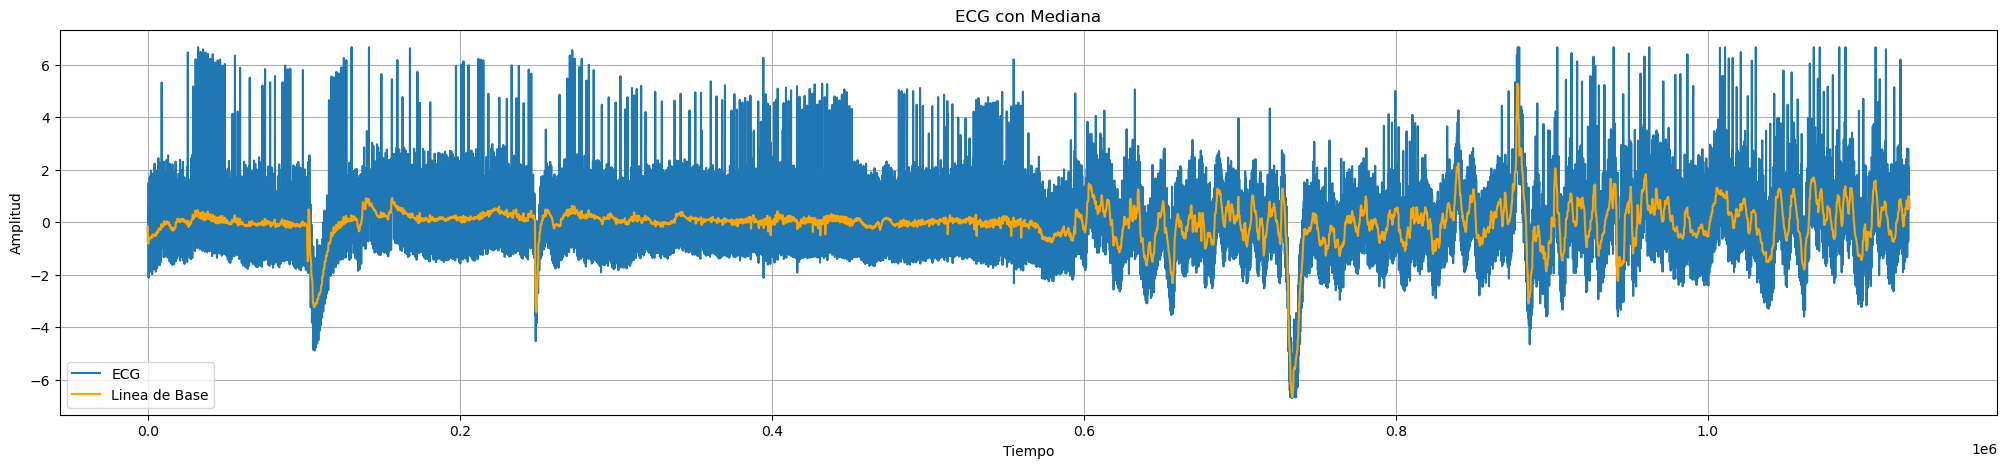

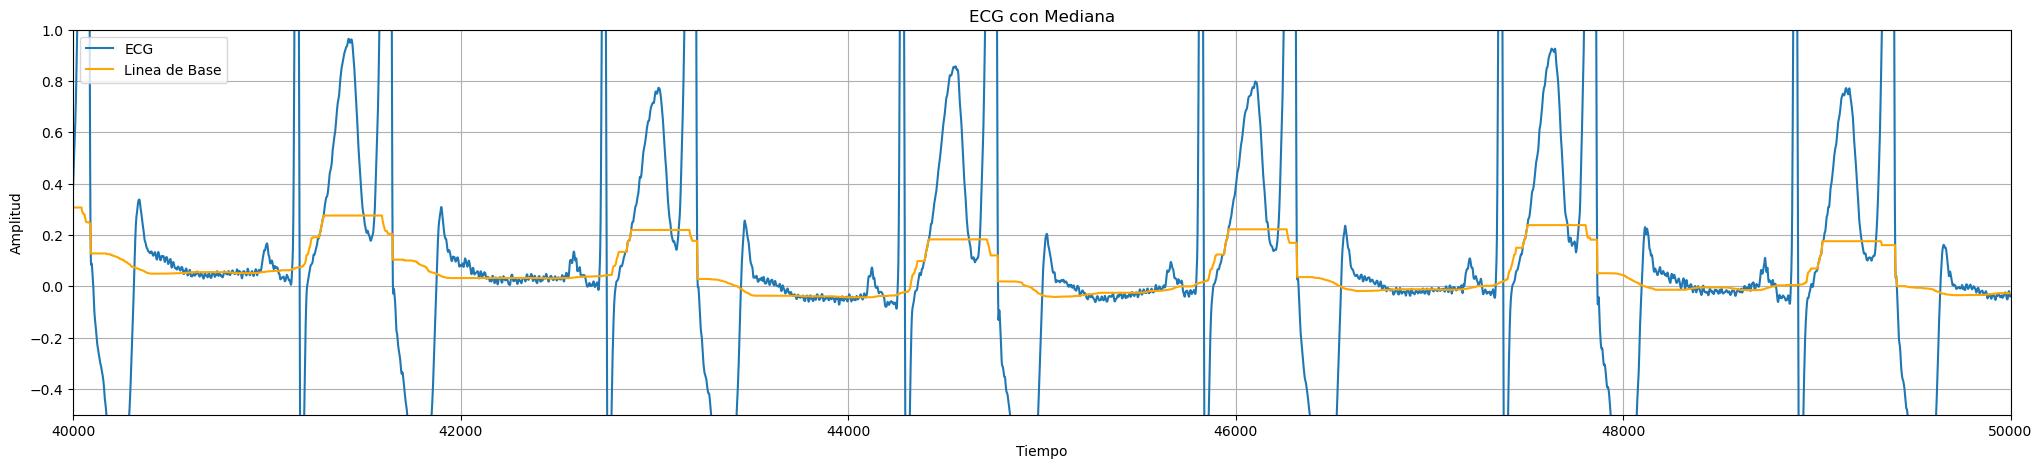

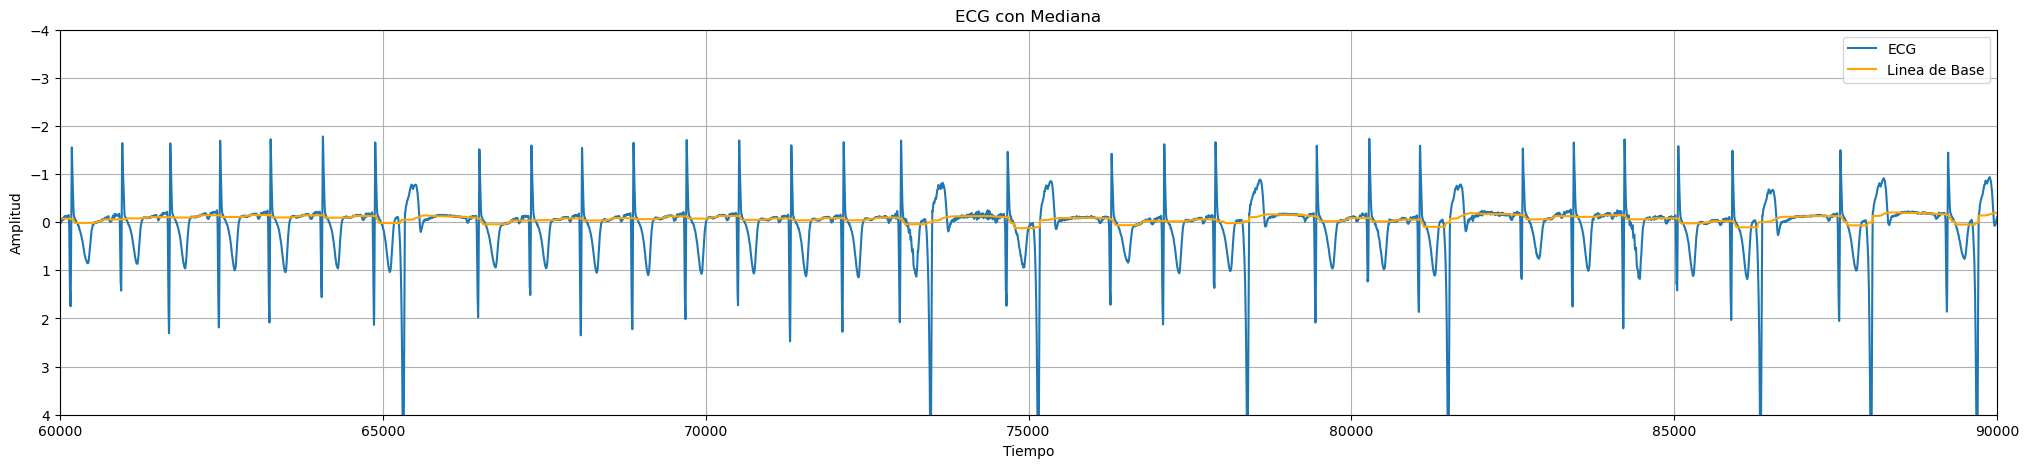

In [3]:
plt.figure(1,figsize=(25, 5))
plt.plot(ecg_one_lead,label='ECG')
plt.plot(b_gorro,label='Linea de Base',color='orange')
plt.title('ECG con Mediana')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

plt.figure(2,figsize=(25, 5))
plt.plot(ecg_one_lead,label='ECG')
plt.plot(b_gorro,label='Linea de Base',color='orange')
plt.title('ECG con Mediana')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.ylim(-0.5,1)
plt.xlim(40000, 50000)
plt.legend()
plt.grid()
plt.show()

plt.figure(3,figsize=(25, 5))
plt.plot(ecg_one_lead,label='ECG')
plt.plot(b_gorro,label='Linea de Base',color='orange')
plt.title('ECG con Mediana')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.ylim(4,-4)
plt.xlim(60000, 90000)
plt.legend()
plt.grid()
plt.show()

Una vez hecho esto se aplica la resta, pero podemos ver como la mediana se adapta bastante como linea de base.

# Interpolacion mediante splines cubicos

Se aplicara una interpolacion con splines cubicos a puntos del registro en donde la actividad cardiaca sea nula, teniendo en cuenta el registro qrs_detections, que estos marcan la ubicaion del maximo del complejo. La manera en la cual se llevo a cabo fue primero estimar la distancia en cantidad de muestras del pico QRS hasta el segmento nulo. Esto da aproximadamente unas 90 muestras, y en punto se le hace un promedio a las siguientes 20 muestras. Para que finalmente se tome ese punto para aplicar el metodo interpolador

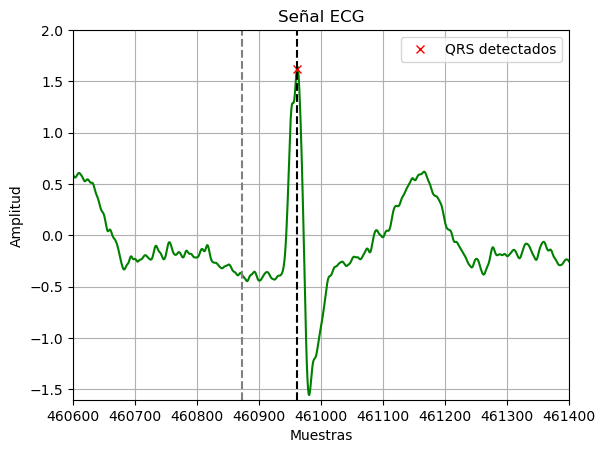

In [4]:

plt.figure(2)
plt.plot(ecg_one_lead[:, 0],color='green')
plt.plot(qrs_picks[:, 0], ecg_one_lead[qrs_picks[:, 0].astype(int), 0], 'rx', label='QRS detectados')
plt.xlim(460600,461400)
plt.ylim(-1.6, 2)
plt.axvline(x=460962, color='black', linestyle='--')
plt.axvline(x=460962-90, color='grey', linestyle='--')
plt.title('Señal ECG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

In [5]:
# %% Aplico el metodo de splines cubicos
qrs_indices = qrs_picks[:, 0].astype(int)

# Inicializamos listas para guardar los puntos de spline
tiempos_spline = []
valores_spline = []

# Recorremos cada QRS
for idx in qrs_indices:
    inicio = idx - 90
    fin = inicio + 20

    # Control de bordes por si la ventana queda fuera del inicio de la señal
    if inicio < 0 or fin > N:
        continue  # Salteamos si la ventana es inválida

    ventana = ecg_one_lead[inicio:fin, 0]
    promedio = np.mean(ventana)

    tiempos_spline.append(inicio)
    valores_spline.append(promedio)

cs = CubicSpline(tiempos_spline, valores_spline)

# Generamos la línea de base estimada para toda la señal
tiempos = np.arange(N)
linea_base_spline = cs(tiempos)

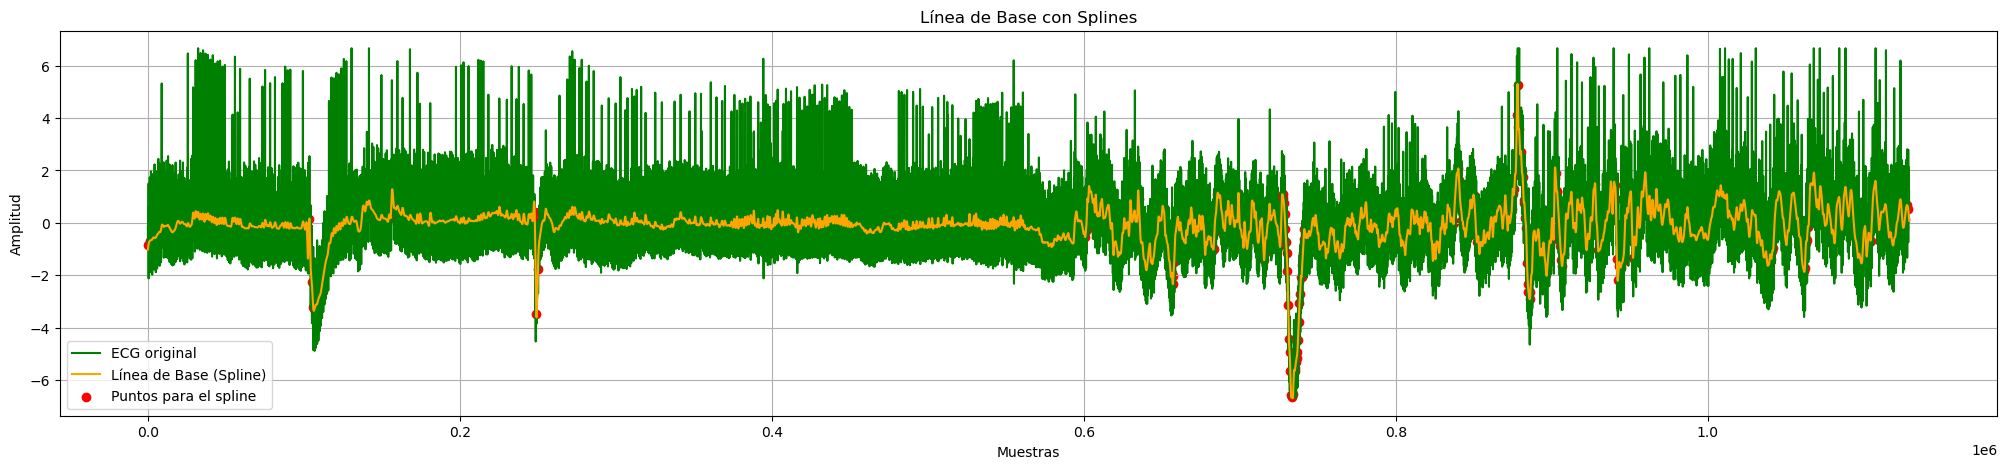

c:\Users\Joaquin\anaconda3\envs\EntornoGit\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


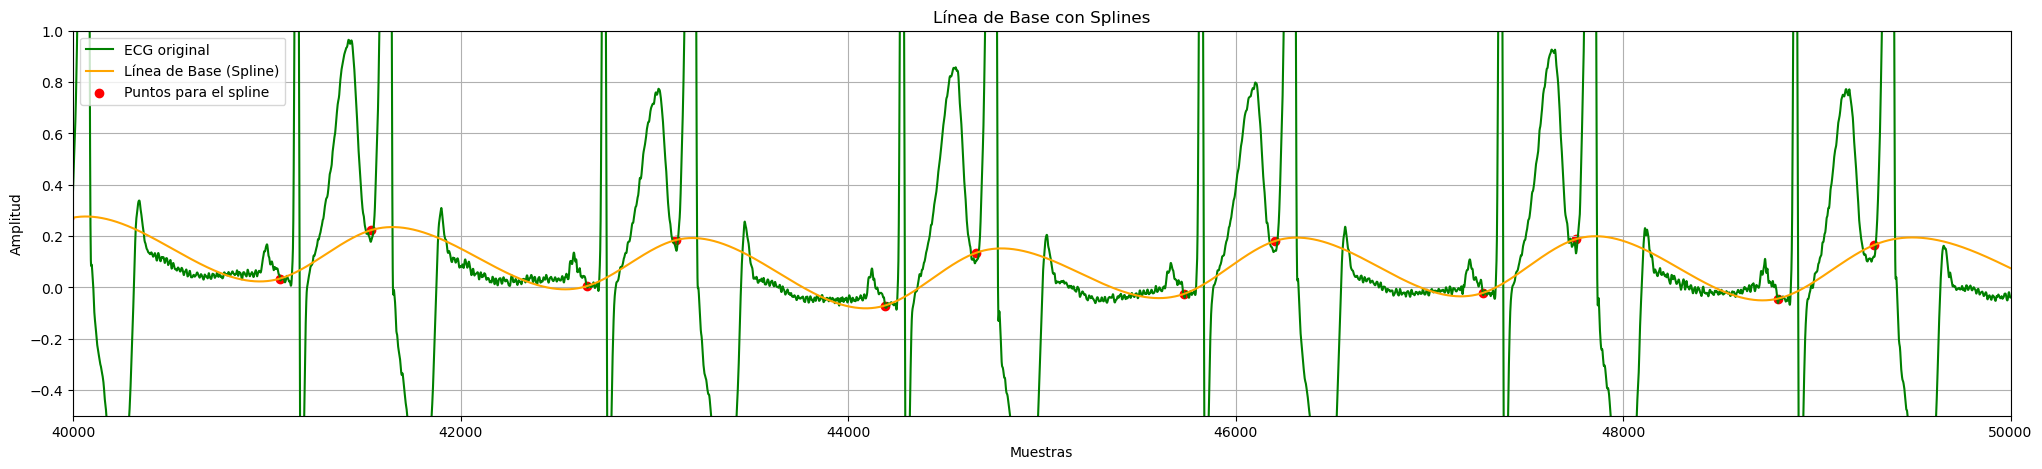

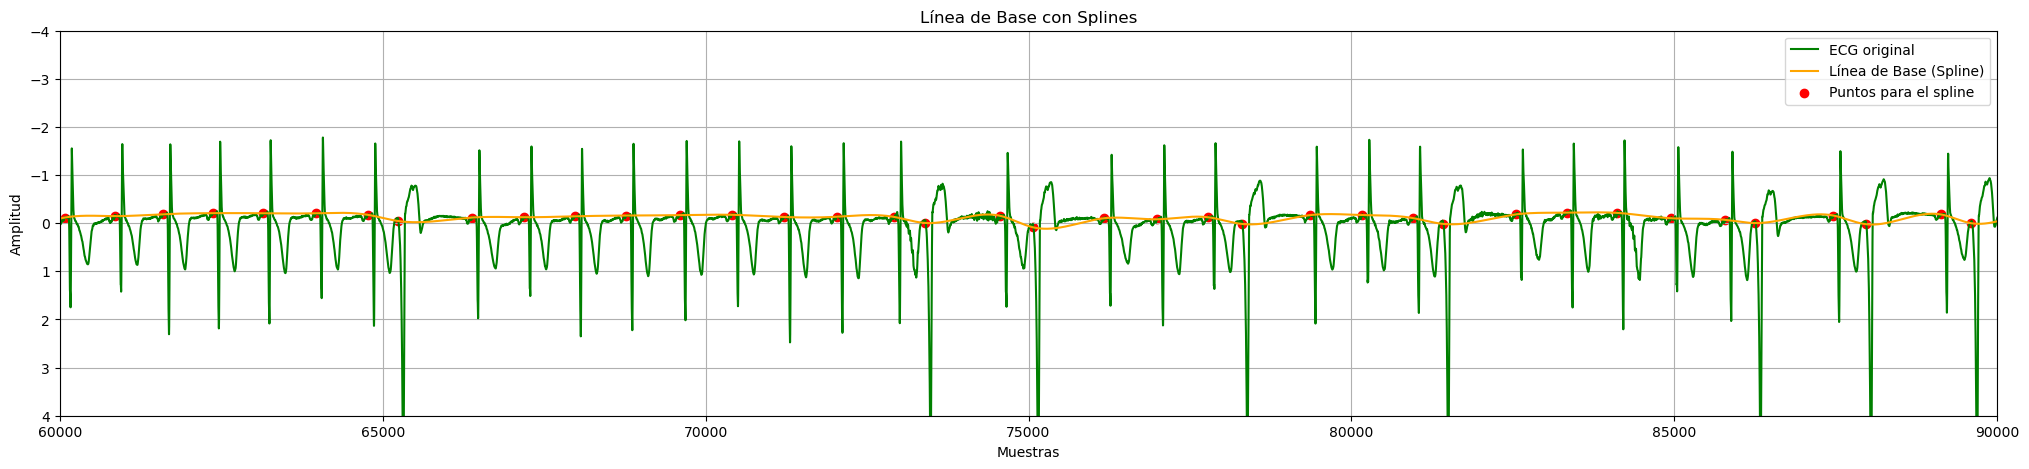

In [6]:
plt.figure(4,figsize=(25, 5))
plt.plot(ecg_one_lead[:, 0], label='ECG original', color='green')
plt.plot(tiempos, linea_base_spline, label='Línea de Base (Spline)', color='orange')
plt.scatter(tiempos_spline, valores_spline, color='red', label='Puntos para el spline')
plt.title('Línea de Base con Splines')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

plt.figure(5,figsize=(25, 5))
plt.plot(ecg_one_lead[:, 0], label='ECG original', color='green')
plt.plot(tiempos, linea_base_spline, label='Línea de Base (Spline)', color='orange')
plt.scatter(tiempos_spline, valores_spline, color='red', label='Puntos para el spline')
plt.ylim(-0.5,1)
plt.xlim(40000, 50000)
plt.title('Línea de Base con Splines')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

plt.figure(6,figsize=(25, 5))
plt.plot(ecg_one_lead[:, 0], label='ECG original', color='green')
plt.plot(tiempos, linea_base_spline, label='Línea de Base (Spline)', color='orange')
plt.scatter(tiempos_spline, valores_spline, color='red', label='Puntos para el spline')
plt.ylim(4,-4)
plt.xlim(60000, 90000)
plt.title('Línea de Base con Splines')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

Nuevamente se hace la resta para obtener la señal filtrada sin la linea de base 

# Filtro Adaptado   

El filtro adaptado se diseñara para detectar latidos, teniendo el registro del ECG y un patron de referencia que en este caso se usara 

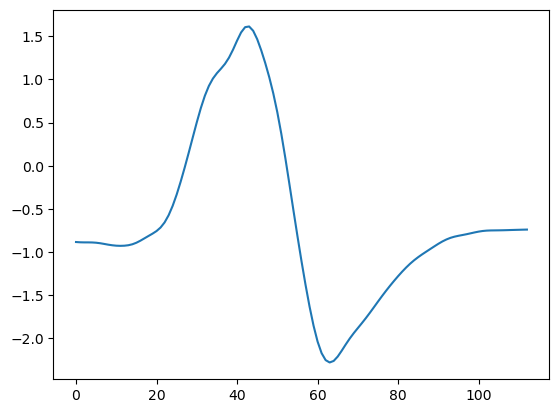

In [7]:
plt.figure(1)
plt.plot(qrs_pattern3)

A este patron de referencia se le aplicara la correlacion con la señal ECG, ya que esta me permite ver que tanto se parece una señal entre si.

In [8]:
# %% Aplico tecnica del filtro matched
corre_ecg = sig.correlate(ecg_one_lead,qrs_pattern3,mode='same')
corre_ecg = corre_ecg / np.std(corre_ecg)
peaks, _ = sig.find_peaks(corre_ecg[:,0],height= 0.2,distance=350)


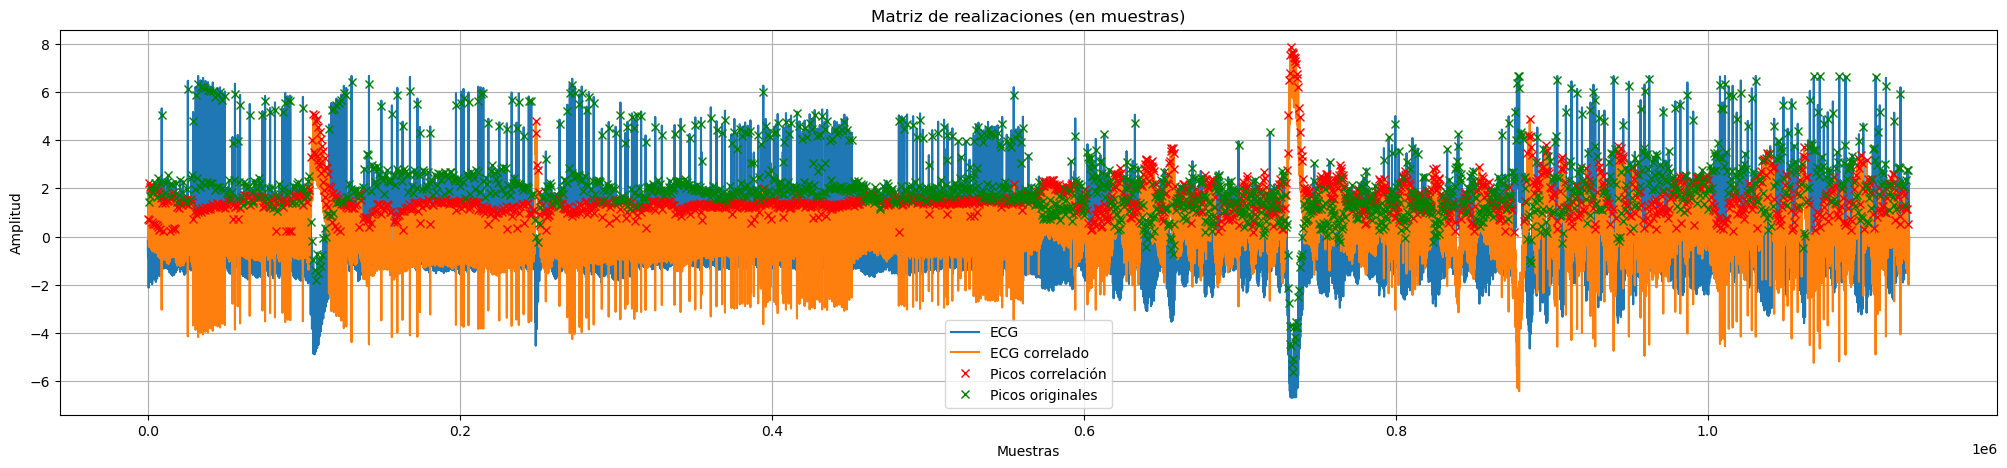

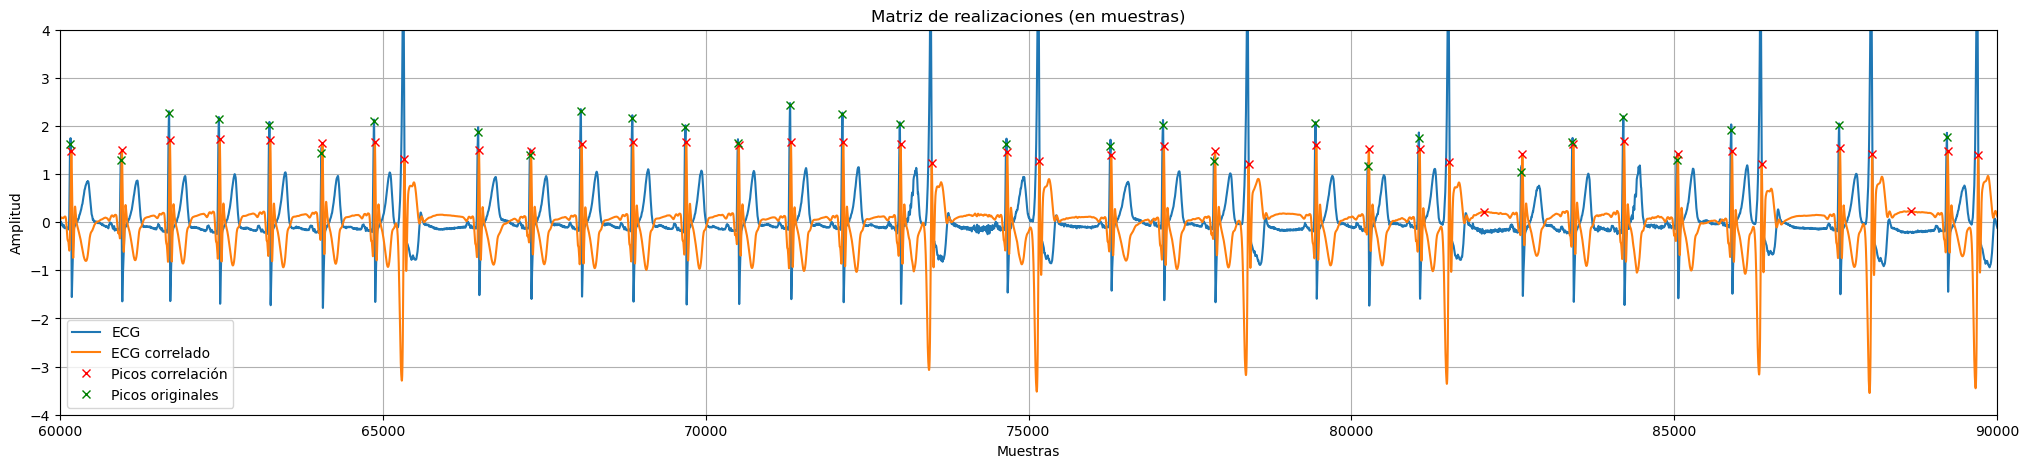

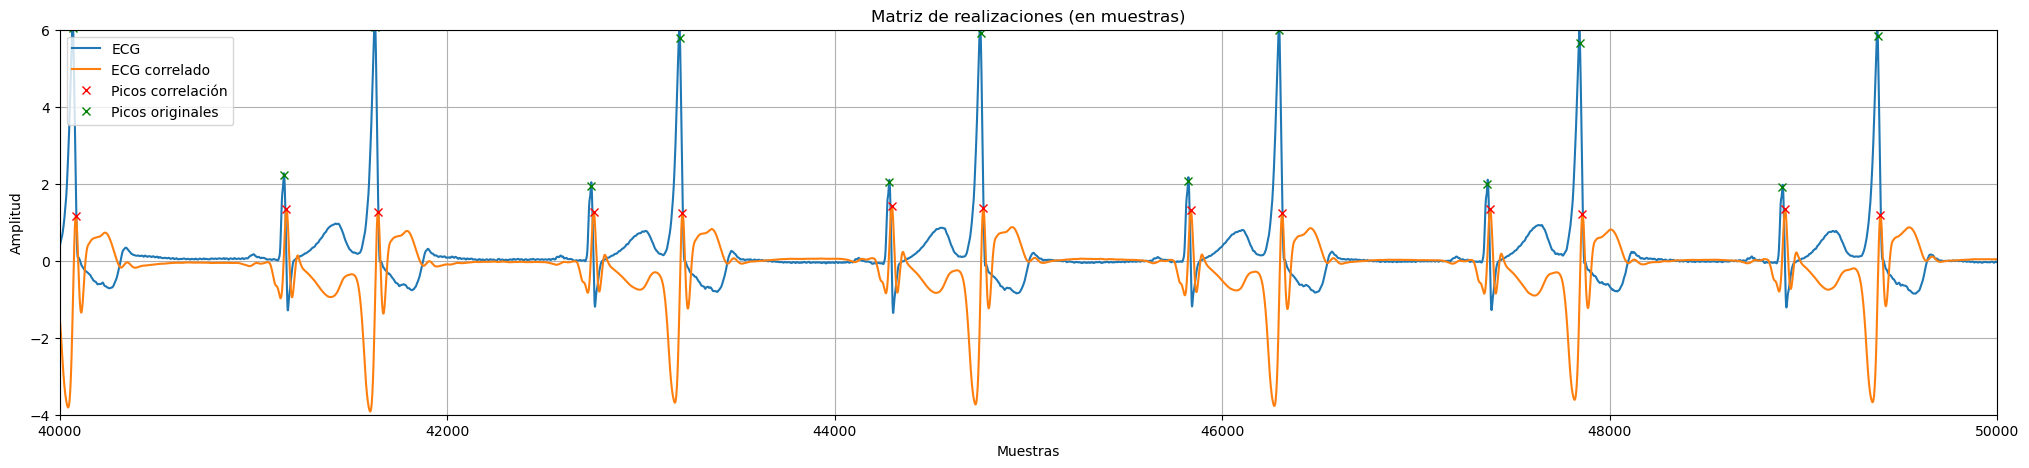

In [9]:
muestras = np.arange(N)

plt.figure(1,figsize=(25, 5))
plt.plot(muestras, ecg_one_lead, label='ECG')
plt.plot(muestras, corre_ecg, label='ECG correlado')
plt.plot(peaks, corre_ecg[peaks], 'rx', label='Picos correlación')
plt.plot(qrs_indices, ecg_one_lead[qrs_indices], 'gx', label='Picos originales')
plt.title('Matriz de realizaciones (en muestras)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()


plt.figure(2,figsize=(25, 5))
plt.plot(muestras, ecg_one_lead, label='ECG')
plt.plot(muestras, corre_ecg, label='ECG correlado')
plt.plot(peaks, corre_ecg[peaks], 'rx', label='Picos correlación')
plt.plot(qrs_indices, ecg_one_lead[qrs_indices], 'gx', label='Picos originales')
plt.ylim(-4,4)
plt.xlim(60000, 90000)
plt.title('Matriz de realizaciones (en muestras)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()


plt.figure(3,figsize=(25, 5))
plt.plot(muestras, ecg_one_lead, label='ECG')
plt.plot(muestras, corre_ecg, label='ECG correlado')
plt.plot(peaks, corre_ecg[peaks], 'rx', label='Picos correlación')
plt.plot(qrs_indices, ecg_one_lead[qrs_indices], 'gx', label='Picos originales')
plt.ylim(-4,6)
plt.xlim(40000, 50000)
plt.title('Matriz de realizaciones (en muestras)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

Para analizar la performance de mi detector de latidos, principalmente para validar la confirmacion de los pulsos, se empleara mediante una tabla de confusion con los valores detectados y los que estan en el qrs_detections. En busca de detectar falsos negativos y positivos y validaciones correctas. 

In [12]:
# %% Matriz de confusion
# Tolerancia en muestras (ajustar según tu fs)
tolerancia = 100

# Convertimos los arrays en sets para facilitar el conteo
qrs_real = np.array(qrs_indices)
qrs_detectados = np.array(peaks)

# Inicializamos contadores
VP = 0
FP = 0
FN = 0

# Creamos una máscara para marcar qué QRS reales fueron detectados
qrs_detectados_mask = np.zeros(len(qrs_real), dtype=bool)

# Contamos Verdaderos Positivos (VP)
for detected_peak in qrs_detectados:
    # Buscamos el QRS real más cercano
    distancia = np.abs(qrs_real - detected_peak)
    idx_min = np.argmin(distancia)
    
    if distancia[idx_min] <= tolerancia:
        # Si cae dentro de la tolerancia, contamos como VP
        VP += 1
        qrs_detectados_mask[idx_min] = True
    else:
        # Si no coincide con ningún QRS real, es un FP
        FP += 1

# Los FN son los QRS reales que no fueron detectados
FN = np.sum(~qrs_detectados_mask)

# Imprimir tabla tipo matriz de confusión
print("\nMatriz de Confusión:")
print("----------------------------")
print("                | QRS real Sí | QRS real No")
print("Detectado Sí    | {:>10}  | {:>10}".format(VP, FP))
print("Detectado No    | {:>10}  | {:>10}".format(FN, "-"))


# Cálculo de métricas
precision = VP / (VP + FP) * 100
recall = VP / (VP + FN) * 100 

print("\nPerformance del filtro:")
print(f"Precisión:    {precision:.2f}%")
print(f"Sensibilidad: {recall:.2f}%")



Matriz de Confusión:
----------------------------
                | QRS real Sí | QRS real No
Detectado Sí    |       1723  |        185
Detectado No    |        180  |          -

Performance del filtro:
Precisión:    90.30%
Sensibilidad: 90.54%


Se observa como al aplicar este algoritmo para detectar picos, tiene una precision y sensibilidad bastante alta con porcentajes, por lo cual se puede decir que es un buen metodo para captar latidos. Sin embargo se podria mejorar cambiando la forma del patron o cambair las condiciones de la funcion de "find_peaks"

# Conclusiones

En busca de otras maneras de filtrar señales con metodos ingeniosos y adaptables, se llega en principio a una buena aplicacion para elimniar ruidos de baja frecuencia, sacandose de encima el ruido de la linea de base de una señal, primero mediante capturar la señal con ventanas cortas en milisegundos y obtener la mediana de esa señal, para que despues, a traveas una referencia de mi registro y un muestreo del mismo, se pudo estimar una distancia de un segmente de actividad nula y mi referencia. Esto permitio aplicar una interpolacion de splines cubica que sigue bien la linea de base. 
Por ultimo, siguiendo una dinamica distinta a lo anterior, un poco mas en el analisis de la señal sobre el procesamiento, en el cual se quizo encontrar la cantidad de latidos que hay en el registro. Para ello se vio que la correlacion de el patron usado y mi señal, es aproximadamente un 90% optimo para alcanzar el objetivo, un resultado derivado de generar un matriz de confusion donde se compararon los valores encontrados por el algortimo y el valor de referencia.